## Load data

In [1]:
import sys
 
sys.path.insert(0, "../../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"../../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data, None)

/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/homogeneous/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [3]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

## Normalize and Concatenate data

In [4]:
# def normalize(tensor):
#     mean = torch.mean(tensor, dim = 0)
#     std = torch.std(tensor, dim = 0)
#     mean_diff = tensor - mean
#     return mean_diff / std

# X_train = normalize(X_train)
# X_test = normalize(X_test)
# X_gw_test = normalize(X_gw_test)

In [5]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

## Train/Validation/Test splits

In [6]:
def true_indices_like(tensor):
    return torch.ones((tensor.shape[0])).type(torch.bool)

def false_indices_like(tensor):
    return torch.zeros((tensor.shape[0])).type(torch.bool)

def split(train_features):
    tensor = true_indices_like(train_features)
    max_index = round(tensor.shape[0] * .8)
    train = torch.zeros(tensor.shape[0])
    train[:max_index] = 1
    
    val = torch.zeros(tensor.shape[0])
    val[max_index:] = 1
    return{
        "train": train.type(torch.bool),
        "val":val.type(torch.bool)
    }
train_data = split(X_train)

train_mask = torch.concat((train_data["train"], false_indices_like(X_test), false_indices_like(X_gw_test)))
val_mask = torch.concat((train_data["val"], false_indices_like(X_test), false_indices_like(X_gw_test)))
test_l_mask = torch.concat((false_indices_like(X_train), true_indices_like(X_test), false_indices_like(X_gw_test)))
test_gw_mask = torch.concat((false_indices_like(X_train), false_indices_like(X_test), true_indices_like(X_gw_test)))

## Construct edges and define graph

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [8]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data

edge_index = knn_graph(torch.from_numpy(scaler.transform(X_all)).type(torch.float),k = 4, loop = True, num_workers = -1)
graph = Data(x= torch.from_numpy(scaler.transform(X_all)).type(torch.float),  edge_index = edge_index, y = y_all)

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Define model

## Model in paper GraphSAGE

In [9]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch
from dataAnalysis.Constants import FEATURES

class GraphNeuralNetwork(torch.nn.Module):
    
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        
        input_dim = len(FEATURES)          
        self.conv1 = SAGEConv(input_dim, hidden_dim, normalize=True, project= True, aggr = "mean", root_weight = True)
        self.conv_end = SAGEConv(hidden_dim, out_channels, aggr = "mean", root_weight = True)
        self._estimator_type = "classifier"
        self.classes_ = [None]


    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

    def fit(self):
        pass

    def __sklearn_is_fitted__(self):
        return True
        
    def var_fun_(self):
        pass

## Shift data to device

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)
WEIGHT = torch.tensor([664])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:0


## Model-Wrapper class

In [11]:
import torch 
from tqdm.notebook import tqdm

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000# 40000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 10    
        self.val_loss = []
        self.train_loss = []
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            out = self.model(self.graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[val_mask]), self.graph.y[val_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.val_loss.append(loss.item())
            if loss.item() > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = loss.item()

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(self.graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[train_mask]), self.graph.y[train_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.train_loss.append(loss.item())
            loss.backward()
            self.optimizer.step()
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
#                 print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(self.epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(self.epochs, self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [12]:
import time 
model_wrapper = ModelWrapper(graph)
start = time.time()
model_wrapper.train()
print(time.time()-start)
model = model_wrapper.get_model()

  0%|          | 0/10000 [00:00<?, ?it/s]

398.8578071594238


## Shift data and model back to CPU for evaluation

In [13]:
graph = graph.cpu()
model = model.cpu()

## Evaluation

In [14]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test.cpu(), y_gw_test.cpu(), X_test.cpu(), X_gw_test.cpu())
evaluation.set_test_args([graph, test_l_mask])
evaluation.set_gw_args([graph, test_gw_mask])

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.050249,0.774915,0.441226,0.009420,0.874125,0.019235
1,Greifswald,0.030679,0.653520,0.397486,0.004721,0.809208,0.005536


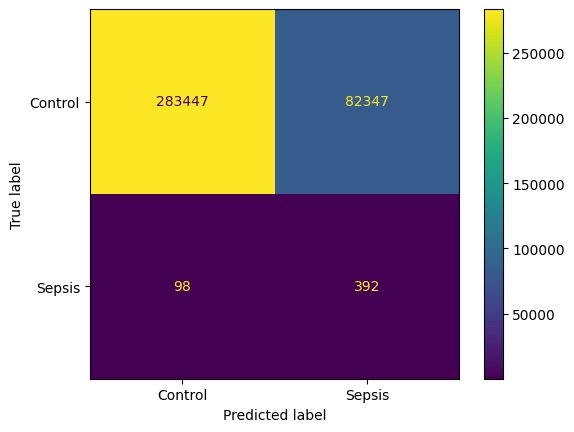

In [15]:
evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

## Partial Dependence

In [16]:
def create_graph(X, edge_index = None):
    edge_index_train = knn_graph(X_train ,k = 4, loop = True, num_workers = -1)
    return Data(x= torch.from_numpy(scaler.transform(X)).type(torch.float),  edge_index = edge_index_train)

In [18]:
from feature_variation.PartialDependence import PartialDependence
partial_dependence = PartialDependence(model, X_train, create_graph=create_graph)
partial_dependence.write_partial_dependence_values("Homogeneous GNN")

  0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
partial_dependence.pdps

{0: array([0.13130495, 0.13241562, 0.13361812, 0.13491635, 0.13631469,
        0.13781753, 0.13942946, 0.14115477, 0.1429981 , 0.14496368,
        0.14705519, 0.149276  , 0.15162905, 0.15411697, 0.15674178,
        0.15950604, 0.162411  , 0.16545998, 0.16865596, 0.17200306,
        0.17550217, 0.17915365, 0.18295717, 0.18690787, 0.19100237,
        0.19523133, 0.19958243, 0.2040419 , 0.20859684, 0.21323399,
        0.2179383 , 0.22269437, 0.22749111, 0.23231734, 0.23716451,
        0.24202345, 0.24689069, 0.25176427, 0.25664312, 0.26152757,
        0.26641989, 0.27131963, 0.27622715, 0.28114045, 0.28605211,
        0.29095414, 0.29583365, 0.30067018, 0.30544695, 0.31014583,
        0.31474742, 0.31923571, 0.32359737, 0.32782462, 0.3319152 ,
        0.33586898, 0.33969215, 0.34339732, 0.34699687, 0.35050336,
        0.35393742, 0.3573111 , 0.36063719, 0.36392131, 0.3671709 ,
        0.37039143, 0.37358743, 0.37676427, 0.37992311, 0.3830626 ,
        0.38618046, 0.38927612, 0.39234841, 0

## Error evaluation

In [ ]:
import time

number_of_iter = 100
dataframes =[]
gnn_models = []
times = []
for i in range(number_of_iter):
#     print(i)
    graph = graph.to(device)
    start = time.time()
    model_wrapper = ModelWrapper(graph)
    model_wrapper.train()
    times.append(time.time()-start)
    print(time.time()- start)
    model = model_wrapper.get_model()
    model = model.cpu()
    graph = graph.cpu()
    df = evaluation.get_df_metrics(model)
    print(df)
    dataframes.append(df)
    gnn_models.append(model)

In [ ]:
for t in times:
    print(t)

In [ ]:
for df in dataframes:
    print(df)